In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
import time
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
select_device(0)

In [48]:
def dqn_feature(hu=676,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, 
                                                                     hidden_units=(hu,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
start = time.time()
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)
print(time.time()-start)

2020-07-05 17:34:29,823 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-07-05 17:34:42,654 - root - INFO: steps 5000, episodic_return_test -180.30(18.69)
2020-07-05 17:34:52,035 - root - INFO: steps 10000, episodic_return_test -23.30(18.64)
2020-07-05 17:35:01,332 - root - INFO: steps 15000, episodic_return_test -83.40(30.11)
2020-07-05 17:35:13,616 - root - INFO: steps 20000, episodic_return_test -65.10(27.95)
2020-07-05 17:35:27,603 - root - INFO: steps 25000, episodic_return_test -64.80(28.01)
2020-07-05 17:35:39,315 - root - INFO: steps 30000, episodic_return_test -7.20(0.87)


70.10621213912964


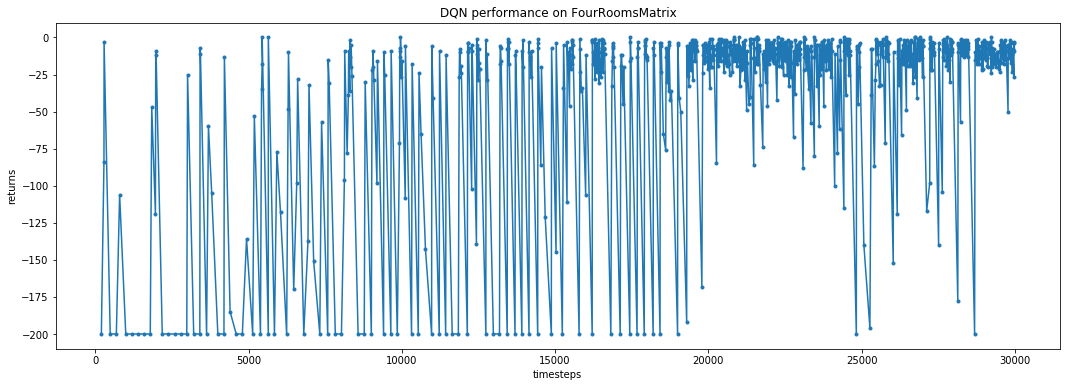

(Text(0.5,1,'DQN performance on FourRoomsMatrix'), None)

In [5]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

In [6]:
print(agent.network)

VanillaNet(
  (fc_head): Linear(in_features=676, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=169, out_features=676, bias=True)
    )
  )
)


In [12]:
weights = list(agent.network.parameters())[2]
biases = list(agent.network.parameters())[3]

In [13]:
weights = weights.detach().cpu().numpy().flatten()
biases = biases.detach().cpu().numpy()

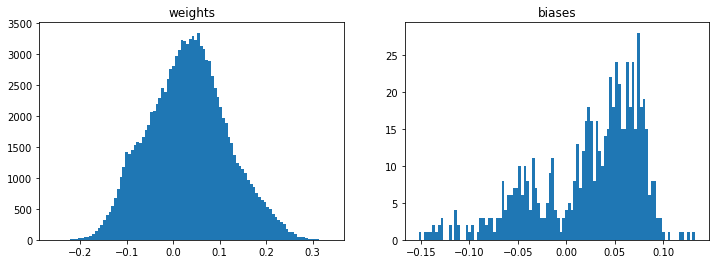

(Text(0.5,1,'biases'), None)

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.hist(weights, bins=100)
plt.title('weights'), plt.subplot(122)
plt.hist(biases, bins=100)
plt.title('biases'), plt.show()

In [15]:
print(weights.shape, biases.shape)
# random shuffling
np.random.shuffle(biases)
np.random.shuffle(weights)
weights = np.reshape(weights, (676, 169))
print(weights.shape, biases.shape)

(114244,) (676,)
(676, 169) (676,)


In [23]:
"""
1. Use these new weights to initialize a network.
2. Fix these weights and fine tune the following layer.
3. See learning performance and save plots.
""" 
# Step 1
import collections
od_weights = collections.OrderedDict()
od_weights['layers.0.weight'] = torch.Tensor(weights)
od_weights['layers.0.bias'] = torch.Tensor(biases)

import pickle
# pickle.dump( od_weights, open( "storage/layer1_noshuffle.p", "wb" ) )
# od_weights = pickle.load( open( "save.p", "rb" ) )

# agent.network.load_state_dict(od_weights, strict=False)

In [30]:
import pickle
# pickle.dump( od_weights, open( "tmp.p", "wb" ) )
od_weights = pickle.load( open( "storage/layer1_noshuffle.p", "rb" ) )

In [58]:
# Step 2
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=0)
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        if(ref == -1):
            print(agent.network.load_state_dict(od_weights, strict=False))
        else:
            print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

SyntaxError: invalid syntax (<ipython-input-58-4c2743c8d4b0>, line 13)

In [57]:
def runNAgents(function, runs, store=False, freeze=0, ref=None,hu=676):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, hu=hu)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [49]:
# r_shuffle = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=-1)
# r_main_676 = runNAgents(dsr_feature_init, runs=3, freeze=0, ref=None)
r_main_16 = runNAgents(dqn_feature, runs=3, freeze=0, ref=None, hu=16)

2020-07-05 18:16:56,697 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-07-05 18:17:00,837 - root - INFO: steps 5000, episodic_return_test -180.00(18.97)
2020-07-05 18:17:05,844 - root - INFO: steps 10000, episodic_return_test -121.10(30.56)
2020-07-05 18:17:11,287 - root - INFO: steps 15000, episodic_return_test -101.50(31.15)
2020-07-05 18:17:16,792 - root - INFO: steps 20000, episodic_return_test -141.70(28.17)
2020-07-05 18:17:21,970 - root - INFO: steps 25000, episodic_return_test -101.20(31.25)
2020-07-05 18:17:27,122 - root - INFO: steps 30000, episodic_return_test -82.80(30.27)
2020-07-05 18:17:32,849 - root - INFO: steps 35000, episodic_return_test -46.30(24.33)
2020-07-05 18:17:39,211 - root - INFO: steps 40000, episodic_return_test -6.10(0.98)
2020-07-05 18:17:43,751 - root - INFO: steps 45000, episodic_return_test -7.20(1.08)
2020-07-05 18:17:49,103 - root - INFO: steps 50000, episodic_return_test -9.50(1.70)
2020-07-05 18:17:50,041 - root - INFO: steps 0, e

In [53]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

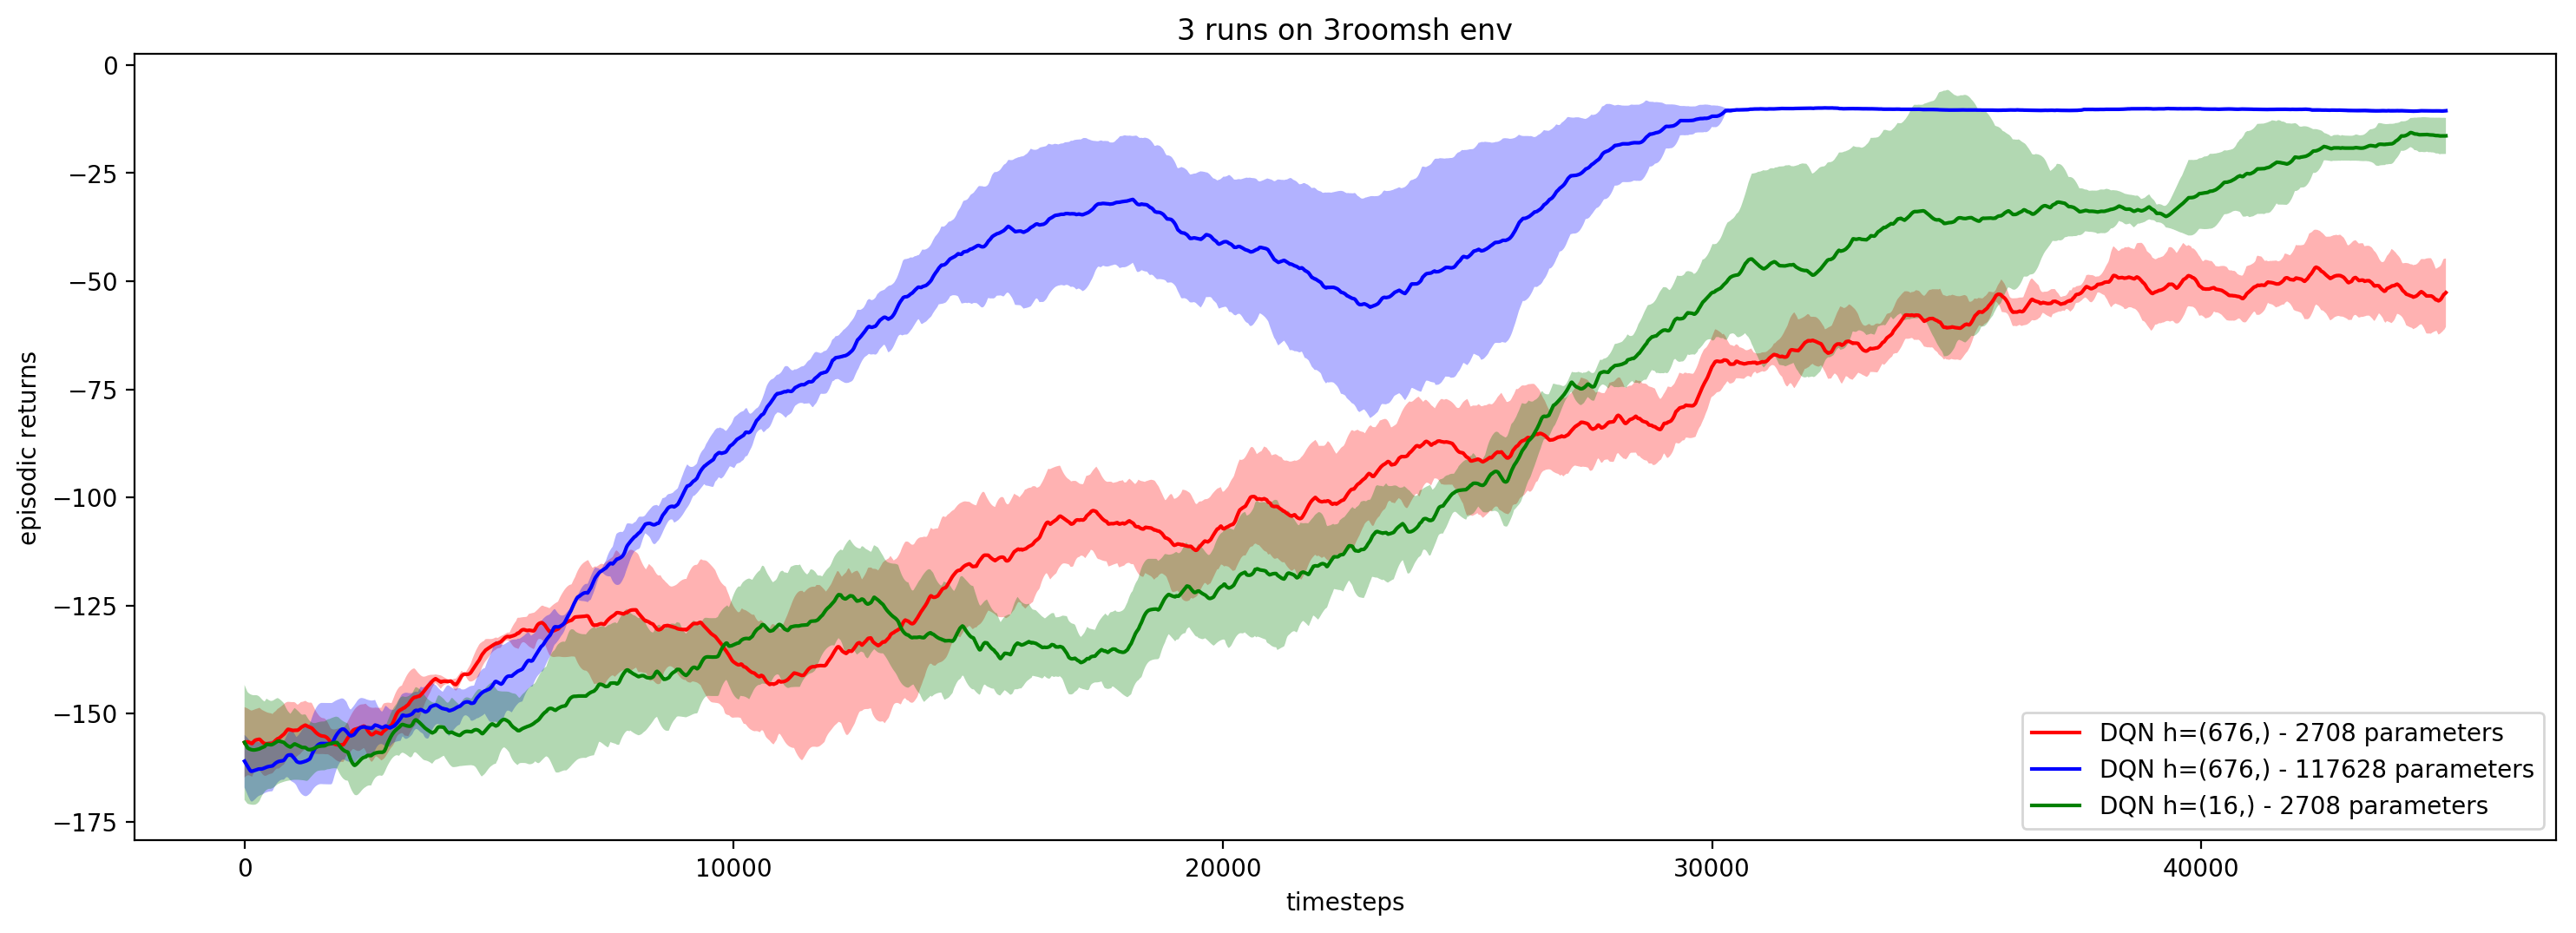

In [54]:
rewards_dict = {
               'DQN h=(676,) - 2708 parameters': r_shuffle,
               'DQN h=(676,) - 117628 parameters': r_main_676,
               'DQN h=(16,) - 2708 parameters': r_main_16
               }
# rewards_dict = {'avDSR, 1eps: 169 learnable params':r_dsr_rand,
#                 'avDSR, 1eps: 2708 learnable params':r_dsr_abs_rand[1:],
#                 'DQN, h=(676,): 117628 learnable params': r_dqn_base,
#                'DQN, h=(16,): 2788 learnable params': r_dqn_base2[1:]}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='3 runs on 3roomsh env')

In [35]:
%pwd

'/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/notebooks'

In [55]:
import pickle

with open("../storage/33-3rooms-baselines.p", 'wb') as f:
    pickle.dump(rewards_dict, f, pickle.HIGHEST_PROTOCOL)
# rewards_dict = pickle.load( open( "storage/33-3rooms-baselines.p", "rb" ) )

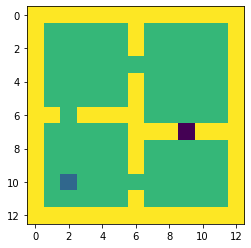

In [39]:
from deep_rl.component.fourrooms import * # CHECK
env = FourRoomsMatrix()
env.reset()
env.reset()
plt.imshow(env.render())